# 1. Importando as bibliotecas que serão utilizadas:


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yahoofinancials as yf
import numpy as np
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import pandas_ta as ta
import datetime as dt

C:\Users\patri\anaconda3\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

# 2. Escolher a ação e datas que serão utilizadas:

In [2]:
print('////////////////////////////////////////////////////////////////////////////')
print('Qual ação quer utilizar para testar no programa?')
print('OBS: para ações brasileiras - "ticker.SA" e para americanas apenas seu ticker. ')
t = input('ação escolhida --> ')
print('////////////////////////////////////////////////////////////////////////////')
print('Qual período quer analisar?')
print('OBS: colocar as datas no seguinte formato: aaaa-mm-dd')
inicio = input('data de início --> ')
fim = input('data final --> ')
print('////////////////////////////////////////////////////////////////////////////')

////////////////////////////////////////////////////////////////////////////
Qual ação quer utilizar para testar no programa?
OBS: para ações brasileiras - "ticker.SA" e para americanas apenas seu ticker. 


ação escolhida -->  BOVA11.SA


////////////////////////////////////////////////////////////////////////////
Qual período quer analisar?
OBS: colocar as datas no seguinte formato: aaaa-mm-dd


data de início -->  2019-01-01
data final -->  2022-01-01


////////////////////////////////////////////////////////////////////////////


# 3. Transformando os dados requeridos em um data Frame contendo as datas e os preços de fechamento ajustado:

In [3]:
ticker = yf.YahooFinancials(t).get_historical_price_data(inicio, fim, 'daily') #busca os dados para a ação escolhida
dados = pd.DataFrame(ticker[t]['prices']) #cria o DataFrame com os dados obtidos
dados = dados.drop(['high','low','open','volume','close','date'],axis=1) #deleta essas colunas
dados.rename(columns={'formatted_date' : 'data', 'adjclose' : 'fechamento'}, inplace=True) #renomeia essas colunas
dados = dados[['data','fechamento']] #troca a ordem das colunas
dados

,data,fechamento
0,2019-01-02,87.900002
1,2019-01-03,88.000000
2,2019-01-04,88.500000
3,2019-01-07,88.480003
4,2019-01-08,88.830002
...,...,...
738,2021-12-23,100.849998
739,2021-12-27,101.599998
740,2021-12-28,101.059998
741,2021-12-29,100.250000


# 4. Gráfico do fechamento ajustado no período  do ativo escolhido:

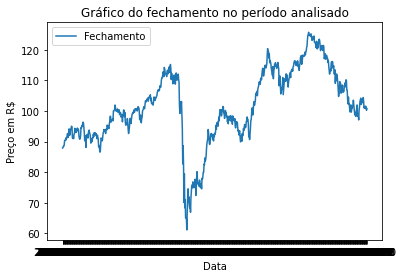

In [4]:
figura1=plt.plot(dados['data'], dados['fechamento'])
plt.title('Gráfico do fechamento no período analisado')
plt.xlabel('Data')
plt.ylabel('Preço em R$')
plt.legend(['Fechamento'])
plt.rcParams['figure.figsize']=[15,10]

# 5. Modificando a base de dados para realizar o backtesting:

In [5]:
dados_mod = pd.DataFrame(ticker[t]['prices'])
dados_mod = dados_mod.set_index(dados_mod['formatted_date']) #põe  a data formatada como index
dados_mod.index = pd.to_datetime(dados_mod.index) #transforma o index em dados no formato de data utilizáveis para conta
dados_mod = dados_mod.drop(['close','date','formatted_date'],axis=1) #deleta essas colunas
dados_mod.rename(columns={'adjclose' : 'Close', 'open' : 'Open','high' : 'High','low' : 'Low', 'volume': 'Volume'}, inplace=True) #renomeia as colunas para funcionar no backtest
dados_mod

,High,Low,Open,Volume,Close
formatted_date,,,,,
2019-01-02,88.260002,84.349998,84.599998,5021260,87.900002
2019-01-03,88.400002,86.800003,87.550003,4300220,88.000000
2019-01-04,89.449997,87.629997,88.199997,2449750,88.500000
2019-01-07,89.320000,88.059998,88.650002,2891360,88.480003
2019-01-08,88.970001,87.870003,88.750000,3441770,88.830002
...,...,...,...,...,...
2021-12-23,101.599998,100.709999,101.599998,5047637,100.849998
2021-12-27,101.800003,100.949997,101.400002,5274352,101.599998
2021-12-28,101.830002,100.589996,101.830002,7167734,101.059998


# 6. Estratégias para utilizar no robô:

In [6]:
#escolha dos parâmetros que serão utilizados na estratégia, nesse caso os períodos para as curvas de curto e longo prazo
print('----------------------------------------------------------------------------------------------------------')
num_curto_prazo = int(input('Quantos dias para a curva de curto prazo? '))
print('----------------------------------------------------------------------------------------------------------')
num_longo_prazo = int(input('Quantos dias para a curva de longo prazo? '))
print('----------------------------------------------------------------------------------------------------------')

#define uma função para cálculo de médias móveis exponenciais\n",
def MME(values, n):
        
        #Returna a média móvel exponencial de `values`,
        #cada passo levando em conta n valores anteriores.
        return ta.ema(pd.Series(values),n) #retorna o valor da média exponencial com passo n

#define uma função para cálculo de médias móveis simples
def MMS(values, n):

    #Returna a média móvel simples de `values`,
    #cada passo levando em conta n valores anteriores.

    return pd.Series(values).rolling(n).mean() #retorna o valor da média simples com passo n
    
#define uma classe para o cruzamento das médias móveis exponenciais que será utilizado no backtest
class MMECross(Strategy):
    # Define dois n para as médias móveis como *class variables* para uma futura otimização
    n_curto = num_curto_prazo
    n_longo = num_longo_prazo
        
    def init(dado):
        # Realiza um pré-cálculo das duas médias móveis exponenciais: a de curto e de longo prazo
        dado.mme_curto = dado.I(MME, dado.data.Close, dado.n_curto)
        dado.mme_longo = dado.I(MME, dado.data.Close, dado.n_longo)
    
    # após recebido certos parâmetros calcula a segunda parte:
    def next(dado):
        # Se MME de curto prazo cruzar acima da de longo prazo,
        # fecha-se qualquer posição de short e compra o ativo
        if crossover(dado.mme_curto, dado.mme_longo):
            dado.position.close()
            dado.buy()
        # Ou, se a MME de curto prazo cruzar abaixo da de longo prazo,
        # fecha-se qualquer posição de long, e vende o ativo
        elif crossover(dado.mme_longo, dado.mme_curto):
            dado.position.close()
            dado.sell()
    
#define uma classe para o cruzamento das médias móveis simples que será utilizado no backtest
class MMSCross(Strategy):
    # Define dois n para as médias móveis como *class variables* para uma futura otimização
    n_curto = num_curto_prazo
    n_longo = num_longo_prazo
    
    def init(dado):
        # Realiza um pré-cálculo das duas médias móveis exponenciais: a de curto e de longo prazo
        dado.mms_curto = dado.I(MMS, dado.data.Close, dado.n_curto)
        dado.mms_longo = dado.I(MMS, dado.data.Close, dado.n_longo)
    
    # após recebido certos parâmetros calcula a segunda parte:
    def next(dado):
        # Se MME de curto prazo cruzar acima da de longo prazo,
        # fecha-se qualquer posição de short e compra o ativo
        if crossover(dado.mms_curto, dado.mms_longo):
            dado.position.close()
            dado.buy()
        # Ou, se a MME de curto prazo cruzar abaixo da de longo prazo,
        # fecha-se qualquer posição de long, e vende o ativo
        elif crossover(dado.mms_longo, dado.mms_curto):
            dado.position.close()
            dado.sell()

----------------------------------------------------------------------------------------------------------


Quantos dias para a curva de curto prazo?  15


----------------------------------------------------------------------------------------------------------


Quantos dias para a curva de longo prazo?  35


----------------------------------------------------------------------------------------------------------


# 7. Backtest da estratégia escolhida:

In [7]:
print('----------------------------------------------------------------------------------')
print('Qual estratégia será utilizada no robô? ')
print('Opções: MME(médias móveis exponenciais) e MMS(médias móveis simples)')
escolha = input('Escolha --> ')
print('----------------------------------------------------------------------------------')
    
if escolha == 'MME': #se esolher como estratégia médias móveis exponenciais:
    
    capital_inicial = float(input('Qual será o capital inicial utilizado na estratégia conduzida pelo robô? ')) #para efeito de comparação, é definido um capital inicial
    
    backtest_estrategia = Backtest(dados_mod, MMECross, cash = capital_inicial, commission= .002) #backtest da estratégia, na qual é utilizada a função \"Backtest\" da biblioteca 'backtesting'
    resultados = backtest_estrategia.run()                                                        # em que é dado a base de dados que será utilizada, a classe da estratégia (nesse caso MMECross), o capital inicial e uma comissão pelos trades
    # cria variável que guarda os resultados do backtest
    
    print('----------------------------------------------------------------------------------')
    print('RESULTADO DO BACKTEST PARA A ESTRATÉGIA DE MÉDIAS MÓVEIS EXPONENCIAIS:')
    print('----------------------------------------------------------------------------------')
    print(resultados)

else: #realização do backtest para o caso de escolher como estratégia a média móvel simples
    capital_inicial = float(input('Qual será o capital inicial utilizado na estratégia conduzida pelo robô? '))
      
    backtest_estrategia = Backtest(dados_mod, MMSCross, cash = capital_inicial, commission= .002)
    resultados = backtest_estrategia.run()
        
    print('----------------------------------------------------------------------------------')
    print('RESULTADO DO BACKTEST PARA A ESTRATÉGIA DE MÉDIAS MÓVEIS SIMPLES:')
    print('----------------------------------------------------------------------------------')
    print(resultados)
    print('----------------------------------------------------------------------------------')


----------------------------------------------------------------------------------
Qual estratégia será utilizada no robô? 
Opções: MME(médias móveis exponenciais) e MMS(médias móveis simples)


Escolha -->  MME


----------------------------------------------------------------------------------


Qual será o capital inicial utilizado na estratégia conduzida pelo robô?  1000


----------------------------------------------------------------------------------
RESULTADO DO BACKTEST PARA A ESTRATÉGIA DE MÉDIAS MÓVEIS EXPONENCIAIS:
----------------------------------------------------------------------------------
Start                     2019-01-02 00:00:00
End                       2021-12-30 00:00:00
Duration                   1093 days 00:00:00
Exposure Time [%]                   92.193809
Equity Final [$]                  1275.720291
Equity Peak [$]                   1309.200302
Return [%]                          27.572029
Buy & Hold Return [%]               14.675769
Return (Ann.) [%]                    8.609699
Volatility (Ann.) [%]               24.765483
Sharpe Ratio                         0.347649
Sortino Ratio                        0.580795
Calmar Ratio                         0.373278
Max. Drawdown [%]                  -23.065142
Avg. Drawdown [%]                   -5.987169
Max. Drawdown Duration      418 days 00:00:00
Avg. Drawdown Duration     

# 8. Gráfico do Backtest:

In [9]:
grafico2 = backtest_estrategia.plot(plot_equity=False, plot_return=False,plot_volume=True, plot_pl=False,plot_drawdown=False, smooth_equity=False,relative_equity=False)

# 9. Tabela dos trades:

In [10]:
trades = resultados['_trades'] #variável que armazena apenas as informações sobre os trades simulados pelo backtest dados os parâmtros escolhidos
#print(trades.head(10))

cross = pd.DataFrame() #calcúlo da diferença entre as curvas de curto e de longo prozo, para que seja possível a vizualização das vezes que há cruzamentos e das vezes que a de curto está acima ou abaixo da de longo\n",
if escolha == 'MME':
    
    cross['cross'] = MME(dados_mod['Close'], num_curto_prazo) - MME(dados_mod['Close'], num_longo_prazo)
    
else:
    cross['cross'] = MMS(dados_mod['Close'], num_curto_prazo) - MMS(dados_mod['Close'], num_longo_prazo)

#dá uma limpada no DataFrame criado
cross.dropna(axis=0,inplace=True)
cross.reset_index(inplace=True) 
cross.rename(columns={'formatted_date':'data'},inplace=True)
#print(cross.head(10))

print('------------------------------------------------------------------')
print('A estratégia utilizada pelo robô foi:', resultados._strategy)
print('------------------------------------------------------------------')
print('Número total de operações: ',resultados['# Trades'])
print('------------------------------------------------------------------')
print('Ao longo das operações o robô teve uma taxa de acerto de:', round(resultados['Win Rate [%]'],2),'%')
print('------------------------------------------------------------------')
print('Tendo como melhor trade um ganho de:',round(resultados['Best Trade [%]'],2),'%')
print('e como pior trade, uma perda de:',round(resultados['Worst Trade [%]'],2),'%' )
print('------------------------------------------------------------------')
print('Ainda, teve uma média de ganho/perda de:',round(resultados['Avg. Trade [%]'],2),'%','nos trades')
print('------------------------------------------------------------------')

------------------------------------------------------------------
A estratégia utilizada pelo robô foi: MMECross
------------------------------------------------------------------
Número total de operações:  17
------------------------------------------------------------------
Ao longo das operações o robô teve uma taxa de acerto de: 41.18 %
------------------------------------------------------------------
Tendo como melhor trade um ganho de: 16.05 %
e como pior trade, uma perda de: -9.07 %
------------------------------------------------------------------
Ainda, teve uma média de ganho/perda de: 1.51 % nos trades
------------------------------------------------------------------


# 10. Gráfico para enxergar os cruzamentos:

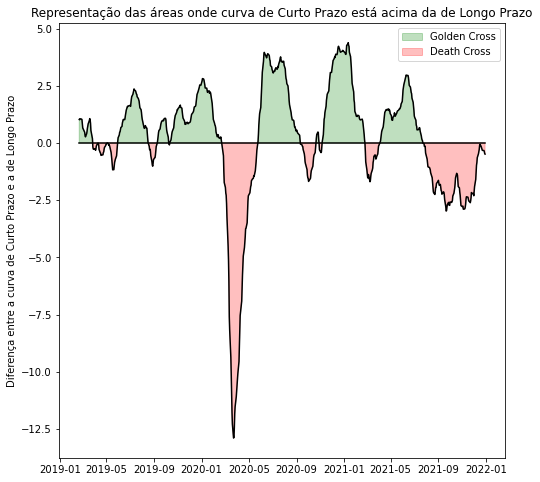

In [11]:
linha_zero = np.zeros(len(cross)) #criação de uma linha de zeros para ajudar na vizualização dos cruzamentos

fig3, ax = plt.subplots(figsize=(8,8))
ax.plot(cross['index'],cross['cross'],color='black')
ax.plot(cross['index'],linha_zero,color='black')

# preencher area quando curva de Curto Prazo > Longo Prazo com verde
ax.fill_between(
    cross['index'], cross['cross'], linha_zero, where=(cross['cross'] > linha_zero), 
    interpolate=True, color="green", alpha=0.25, 
    label="Golden Cross"
    )
# preencher area quando curva de Curto Prazo <= Longo Prazo com vermelho\n",
ax.fill_between(
    cross['index'], cross['cross'], linha_zero, where=(cross['cross'] <= linha_zero), 
    interpolate=True, color="red", alpha=0.25,
    label="Death Cross",
    )

plt.title('Representação das áreas onde curva de Curto Prazo está acima da de Longo Prazo')
plt.ylabel('Diferença entre a curva de Curto Prazo e a de Longo Prazo')
plt.legend()

# 11. Gráfico contendo as decisões de compra e venda e as datas onde houveram lucros e prejuízos:

In [12]:
grafico4 = backtest_estrategia.plot(plot_equity=False, plot_return=False,plot_volume=True, plot_pl=True,plot_drawdown=False, smooth_equity=False,relative_equity=False)

# 12. Tabela com a progressão do patrimônio e os drawdowns:

In [13]:
progressao = resultados['_equity_curve']  #DataFrame que armazena apenas informações sobre a progressão do patrimônio e dos drawdowns da estratégia no backtest
#progressao.head(10)

pico_patrimonio = resultados['Equity Peak [$]'] #identifica o pico de patrimônio
pct_pico = (pico_patrimonio/capital_inicial)-1 #identifica qual o crescimento em relação ao capital inicial do pico de patrimônio
patrimonio_final_robo = resultados['Equity Final [$]'] #identifica o patrimônio final da estratégia no backtest
patrimonio_final_buy_and_hold = (1 + (resultados['Buy & Hold Return [%]']/100))*capital_inicial #identifica qual seria o patrimônio final caso tivesse comprado o ativo no início do período analisado e vendido apenas no fim

print('-------------------------------------------------------------------------------------------------------')
print('O patrimônio inicial era de: R$', round(capital_inicial,2))
print('Já o patrimônio final obtido ao investir pelo robô foi: R$', round(patrimonio_final_robo,2))
print('No entanto, o pico no patrimônio foi no valor de: R$', round(pico_patrimonio,2),',ou seja, valorização máxima de',round(pct_pico,3)*100,'%')
print('-------------------------------------------------------------------------------------------------------')
print('Se tivesse investido seguindo a estratégia do BUY AND HOLD, o patrimônio final seria de: R$',round(patrimonio_final_buy_and_hold,2))
print('-------------------------------------------------------------------------------------------------------')
print('Além disso, o maior Drawdown no patrimônio, ao utilizar o robô, foi de:', round(resultados['Max. Drawdown [%]'],2),'% ,')
print('com uma média de Drawdown de:', round(resultados['Avg. Drawdown [%]'],2),'%')
print('-------------------------------------------------------------------------------------------------------')

-------------------------------------------------------------------------------------------------------
O patrimônio inicial era de: R$ 1000.0
Já o patrimônio final obtido ao investir pelo robô foi: R$ 1275.72
No entanto, o pico no patrimônio foi no valor de: R$ 1309.2 ,ou seja, valorização máxima de 30.9 %
-------------------------------------------------------------------------------------------------------
Se tivesse investido seguindo a estratégia do BUY AND HOLD, o patrimônio final seria de: R$ 1146.76
-------------------------------------------------------------------------------------------------------
Além disso, o maior Drawdown no patrimônio, ao utilizar o robô, foi de: -23.07 % ,
com uma média de Drawdown de: -5.99 %
-------------------------------------------------------------------------------------------------------


# 13. Gráfico do patrimônio e do drawdown:

In [14]:
grafico5 = backtest_estrategia.plot(plot_equity=True, plot_return=False,plot_volume=False, plot_pl=False,plot_drawdown=True, smooth_equity=False,relative_equity=False)

# 14. Cálculo dos retornos diários do ativo analisado, do retorno por operação do robô e o retorno acumulado dos dois:

In [15]:
retorno_buy_and_hold = pd.DataFrame() #DataFrame que comportará os retornos diários e acumulados do caso do buy and hold
retorno_buy_and_hold['data'] = dados['data']
    
retorno_robo = pd.DataFrame() #DataFrame que comportará os retornos diários e acumulados do caso do robô
    
#define uma função para os retornos diários
def retornos(fechamento):
    retornos=[0] #o primeiro dado será vazio pois não é possível o cálculo do retorno para ele
    for i in range(1,len(fechamento)): 
         retornos.append(fechamento[i]/fechamento[i-1] -1) #cálculo do retorno
    return np.array(retornos)

retorno_buy_and_hold['retornos diários'] = retornos(dados['fechamento']) #adiciona ao DataFrame criado, os retornos diários para o buy and hold
retorno_robo['retornos por operação'] = trades['ReturnPct'] #adiciona ao DataFrame criado, os retornos por trade (já foram calculados anteriormente na coluna 'ReturnPct' da variável trades)
    
#define uma função para os retornos acumulados
def retornos_acumulados(retornos_por_periodo):
    capital = 1 #define um capital inicial de 1
    retornos = [] #e uma lista vazia de retornos
    for r in retornos_por_periodo:
        capital += capital*r #calcula o crescimento do patrimônio ao longo dos retornos diários/por trades calculados anteriormente
        retornos.append(capital-1) #retorno então seria esse crescimento menos 1
    return retornos
    
retorno_buy_and_hold['retornos acumulados'] = retornos_acumulados(retorno_buy_and_hold['retornos diários']) #adiciona ao DataFrame criado, o cálculo dos retornos acumulados do buy and hold
tam_buy_and_hold=len(retorno_buy_and_hold) #vê o tamanho do DataFrame

retorno_robo['retornos acumulados'] = retornos_acumulados(retorno_robo['retornos por operação']) #adiciona ao DataFrame criado, o cálculo dos retornos acumulados da estratégia do robô
tam_robo=len(retorno_robo)  #vê o tamanho do DataFrame

#define uma função para que seja calculado quantos anos possui o período da análise
def anos(data_final,data_inicial):
    return int(((data_final - data_inicial).days)/365)
    
data_final = dt.datetime.strptime(fim, '%Y-%m-%d').date() #transforma a data final em forma de data
data_inicial = dt.datetime.strptime(inicio, '%Y-%m-%d').date() #transforma a data inicial em forma de data
n_anos = anos(data_final,data_inicial) #calcula o número de anos usando a função criada
    
retorno_anualizado_buy_and_hold = (1 + retorno_buy_and_hold['retornos acumulados'][tam_buy_and_hold-1])**(1/n_anos) - 1 #cálculo do retorno anualizado, utilizando o retorno acumulado final e o número de anos da análise para o buy and hold
retorno_anualizado_robo = (1 + retorno_robo['retornos acumulados'][tam_robo-1])**(1/n_anos) - 1  #cálculo do retorno anualizado, utilizando o retorno acumulado final e o número de anos da análise para a estratégia do robô
    
print('-----------------------------------------------------------------------')
print('Retornos diários e acumulados da estratégia BUY AND HOLD:')
print('-----------------------------------------------------------------------')
print(retorno_buy_and_hold.tail(10))
print('-----------------------------------------------------------------------')
print('Retornos diários e acumulados da estratégia do ROBÔ:')
print('-----------------------------------------------------------------------')
print(retorno_robo.tail(10))
print('-----------------------------------------------------------------------')
print('O retorno acumulado total da estratégia BUY AND HOLD foi de: ', round(retorno_buy_and_hold['retornos acumulados'][tam_buy_and_hold-1]*100,2),'%')
print('Já o retorno acumulado total da estratégia do robô de: ', round(retorno_robo['retornos acumulados'][tam_robo-1]*100,2),'%')
print('-----------------------------------------------------------------------')
print('Ainda, o retorno anualizado da estratégia BUY AND HOLD foi de:' ,round(retorno_anualizado_buy_and_hold*100,2),'%')
print('enquanto o retorno anualizado do robô foi de:', round(retorno_anualizado_robo*100,2),'%')
print('-----------------------------------------------------------------------')
print('Além disso, a volatilidade anual da estratégia do robô foi de:', round(resultados['Volatility (Ann.) [%]'],2),'%')
print('-----------------------------------------------------------------------')

-----------------------------------------------------------------------
Retornos diários e acumulados da estratégia BUY AND HOLD:
-----------------------------------------------------------------------
           data  retornos diários  retornos acumulados
733  2021-12-16          0.011725             0.187827
734  2021-12-17         -0.012547             0.172924
735  2021-12-20         -0.020369             0.149033
736  2021-12-21          0.004158             0.153811
737  2021-12-22          0.000099             0.153925
738  2021-12-23         -0.005718             0.147326
739  2021-12-27          0.007437             0.155859
740  2021-12-28         -0.005315             0.149716
741  2021-12-29         -0.008015             0.140501
742  2021-12-30          0.005486             0.146758
-----------------------------------------------------------------------
Retornos diários e acumulados da estratégia do ROBÔ:
--------------------------------------------------------------------

# 15. Gráfico de comparação de retornos e rentabilidades acumuladas entre as duas estratégias:

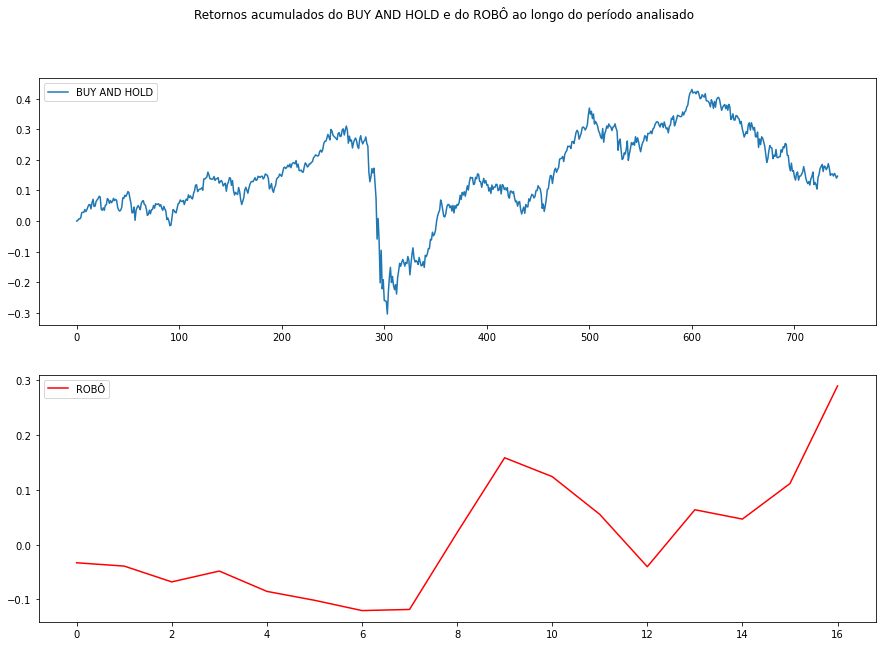

In [17]:
grafico6 = backtest_estrategia.plot(plot_equity=False, plot_return=True,plot_volume=False, plot_pl=False,plot_drawdown=False, smooth_equity=False,relative_equity=False)

fig7_8, (ax7, ax8) = plt.subplots(2)
fig7_8.suptitle('Retornos acumulados do BUY AND HOLD e do ROBÔ ao longo do período analisado')
ax7.plot(retorno_buy_and_hold['retornos acumulados'])
ax7.legend(['BUY AND HOLD'],loc="upper left")
#ax7.rcParams['figure.figsize']=[15,10]
ax8.plot(retorno_robo['retornos acumulados'], color='red')
ax8.legend(['ROBÔ'],loc="upper left")
#ax8.rcParams['figure.figsize']=[15,10]

# 16. Otimização de parâmetros:

In [18]:
otimizacao_patrimonio = backtest_estrategia.optimize(n_curto=range(5, 55, 5),
                        n_longo=range(10, 200, 5),
                        maximize='Equity Final [$]',
                        constraint=lambda param: param.n_curto < param.n_longo)
#otimização do parâmetro número de dias para as curvas de curto e longo prazo do backtest para o período,
#fornecendo um range de dias possíveis para a curva de curto e longo prazo, indicando que quer maximizar o patrimônio final,
#tendo como limite que o número de dias para a curva de curto prazo não pode ser maior que para a de longo prazo.
print('------------------------------------------------------------------------------------------------')
print(otimizacao_patrimonio)

# mostra qual o número de dias otimizados para a estratégia
print('------------------------------------------------------------------------------------------------')

n_otimo = otimizacao_patrimonio._strategy
print('O número de dias para as curvas de curto e longo prazo que otimizam o patrimônio final são:')
print(n_otimo)
print('------------------------------------------------------------------------------------------------')

C:\Users\patri\anaconda3\lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 335 configurations.
  output = _optimize_grid()


  0%|          | 0/9 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------
Start                     2019-01-02 00:00:00
End                       2021-12-30 00:00:00
Duration                   1093 days 00:00:00
Exposure Time [%]                   85.598923
Equity Final [$]                   1671.47448
Equity Peak [$]                   1719.834495
Return [%]                          67.147448
Buy & Hold Return [%]               14.675769
Return (Ann.) [%]                   19.033101
Volatility (Ann.) [%]               26.704188
Sharpe Ratio                         0.712738
Sortino Ratio                        1.310292
Calmar Ratio                         0.872555
Max. Drawdown [%]                  -21.813076
Avg. Drawdown [%]                   -3.917998
Max. Drawdown Duration      290 days 00:00:00
Avg. Drawdown Duration       32 days 00:00:00
# Trades                                    6
Win Rate [%]                        83.333333
Best Trade [%]               

# 17. Gráfico da otimização:

In [19]:
grafico9 = backtest_estrategia.plot(plot_equity=True, plot_return=False,plot_volume=True, plot_pl=True,plot_drawdown=False, smooth_equity=False,relative_equity=True)